In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
from scipy.stats import norm

In [2]:
def sigma2(t, b_min = 0.1, b_max = 20.0):
  return 1.0 -  torch.exp(-(t*b_min + (t**2)/2*(b_max-b_min)))

def mu(t, b_min = 0.1, b_max = 20.0):
  return torch.exp(-1/2*(t*b_min + (t**2)/2*(b_max-b_min)))

In [3]:
def sample(t, x0, M, b_min = 0.1, b_max = 20.0):
  ''''
    x_0: A matrix (n, d)
    t: A vector with size (k)

    return sample of size (n*k*m, d+1)
  '''

  mean = mu(t)
  var = sigma2(t)
  samples = torch.zeros((x0.shape[0]*t.shape[0]*M, x0.shape[1] + 1)).to(device)
  c = 0
  N = x0.shape[0]
  d = x0.shape[1]
  for j in range(t.shape[0]):
    for l in range(M):
      sample_aux = torch.normal(x0*mean[j], std = torch.sqrt(var[j])).to(device)
      samples[c*N:(c+1)*N, 0:d] = sample_aux
      samples[c*N:(c+1)*N, d] = t[j]*torch.ones(N, device=device)
      c += 1
  return samples

def loss_fn(model, x, b_min = 0.1, b_max = 20.0, M = 30, eps=1e-4, T = 1.0, N = 20):
  step = (T-eps)/N
  t = torch.arange(eps, T, step)
  t = torch.concatenate((t, torch.tensor([1.0])))
  t = t.to(device)
  samples = sample(t, x, M, b_min = b_min, b_max = b_max).to(device)
  t = samples[:, -1].reshape(-1,1)
  x = x.repeat(samples.shape[0]//x.shape[0] ,1)
  mean = x.to(device) * mu(t, b_min = b_min, b_max = b_max).to(device)
  var =  sigma2(t, b_min = b_min, b_max = b_max).to(device)
  score_match = -(samples[:, :-1] - mean) / var
  score = model(samples)
  loss = torch.mean(var*(score - score_match)**2)
  return loss

In [4]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            #torch.nn.Linear(128, 128),
            #torch.nn.ReLU(),
            torch.nn.Linear(128, 1),
        )

    def forward(self, x):
        logits = self.net(x)
        return logits

In [5]:
distribution = torch.distributions.Bernoulli(0.5)
ber = distribution.sample((5000,1))
Data = (1/2*torch.randn((5000,1)) - 3)*ber + (torch.randn((5000,1)) + 3) *(1-ber)

<Axes: ylabel='Density'>

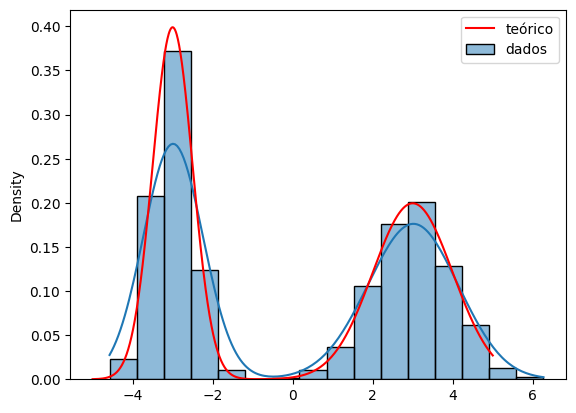

In [6]:
#sns.histplot(Data.cpu().numpy(), stat='density', kde = True)
x = np.linspace(-5, 5, 1000)
y = np.array(1/2*norm.pdf(x,-3,1/2)) + np.array(1/2*norm.pdf(x,3,1))
sns.histplot(Data.cpu().numpy(), stat='density', kde = True, label = 'dados')
sns.lineplot(x=x, y=y, color='red', label='teórico')

<Axes: ylabel='Density'>

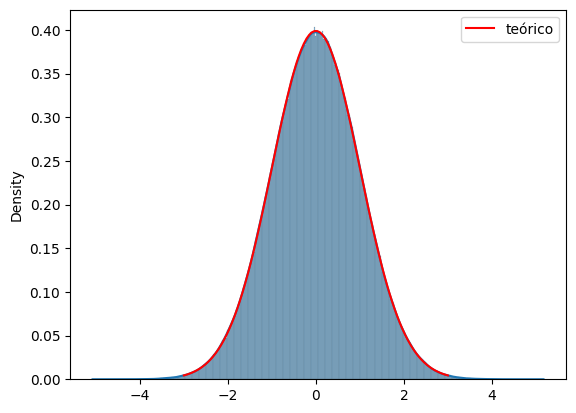

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Noise = sample(torch.ones(500,1).to(device), Data.to(device), 1)[:,0]
sns.histplot(Noise.cpu().numpy(), stat='density', kde = True)
#y = np.array(1/2*norm.pdf(x,-3,1)) + np.array(1/2*norm.pdf(x,3,1))
x = np.linspace(-3, 3, 100)
y = np.array(norm.pdf(x,0,1))
sns.lineplot(x=x, y=y, color='red', label='teórico')

In [8]:
from torch.optim import Adam
from torch.utils.data import DataLoader
model = NeuralNetwork()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Data = Data.to(device)
model = model.to(device)

lr = 1e-4
n_epochs = 300
batch_size = 64
optimizer = Adam(model.parameters(), lr = lr)
data_loader = DataLoader(Data, batch_size=batch_size, shuffle=True)

In [9]:
# treino
for epoch in range(n_epochs):
  avg_loss = 0.
  num_items = 0
  for x in data_loader:
    optimizer.zero_grad()
    loss = loss_fn(model, x, M = 10, N = 100)
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  if epoch % 10 == 0:
    print('Average Loss: {:5f}'.format(avg_loss / num_items))

Average Loss: 0.734435
Average Loss: 0.396167
Average Loss: 0.363143


KeyboardInterrupt: 

In [10]:
def generate(model, N, d = 100, T = 1, b_min = 0.1, b_max = 20):
  X = torch.randn((d,1))
  dt = T/N
  eps = 0#1e-4
  T = T - eps
  def beta(t):
    return b_min + (b_max - b_min)*t
  for i in range(N):
    t = i*T/N
    W = torch.randn((d,1))
    xt = torch.cat((X, (T-t)*torch.ones((d,1))), dim = 1)
    X = X - (-1/2*beta(T-t)*X - beta(T-t)*model(xt.to(device)).cpu())*dt + np.sqrt(beta(T-t)*dt) * W
  return X

In [11]:
import gc
gc.collect() # Run garbage collection to free up memory
torch.cuda.empty_cache() # Empty CUDA cache

In [16]:
sample_new = generate(model, 100, d = 100_000)

<Axes: ylabel='Density'>

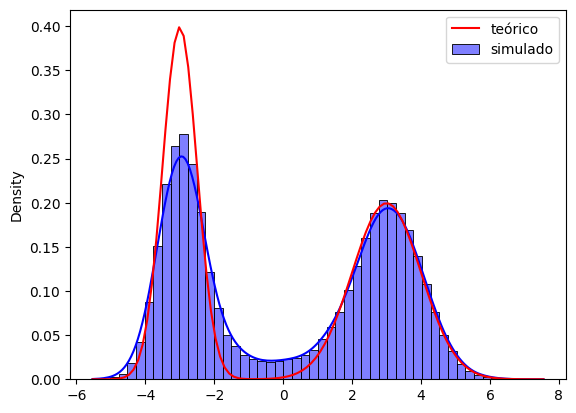

In [18]:
from scipy.stats import norm
l = sample_new.detach().numpy()
#sns.histplot(l, stat='density', kde = True)
x = np.linspace(min(l), max(l), 100)
y = np.array(1/2*norm.pdf(x,-3,1/2)) + np.array(1/2*norm.pdf(x,3,1))
sns.histplot(l[:,0], kde=True, color='blue', label='simulado', stat='density')
#sns.kdeplot(l, color='red', label='simulado')
#sns.kdeplot(Data.cpu()[:,0], color = 'orange', label = 'dado')
sns.lineplot(x=x[:,0], y=y[:,0], color='red', label='teórico')

In [14]:
del sample_new
import gc
gc.collect() # Run garbage collection to free up memory
torch.cuda.empty_cache() # Empty CUDA cache

<Axes: ylabel='Density'>

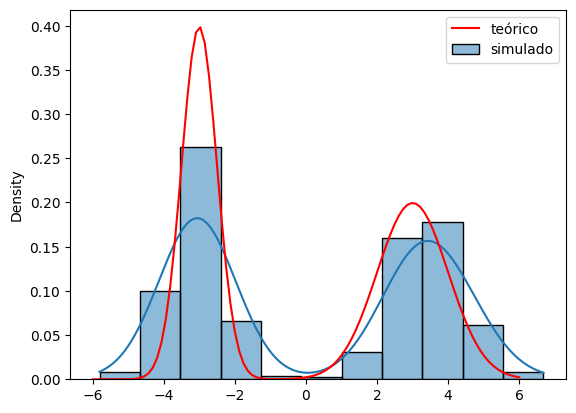

In [64]:
### amostrar por Langevin
X = torch.randn((1000, 1)).to(device)
N = 1000
T = 100
t = 1e-4*torch.ones((1000, 1)).to(device)
dt = T/N
for i in range(N):
  xt = torch.cat((X,t), dim = 1)
  W = torch.randn_like(X)
  X = X + model(xt)/2*dt + np.sqrt(dt)*W
sns.histplot(X.cpu().detach().numpy(), kde=True, color='blue', label='simulado', stat='density')
x = np.linspace(-6, 6, 100)
y = np.array(norm.pdf(x,3,1))/2 + np.array(norm.pdf(x,-3,1/2))/2
sns.lineplot(x=x, y=y, color='red', label='teórico')

<Axes: >

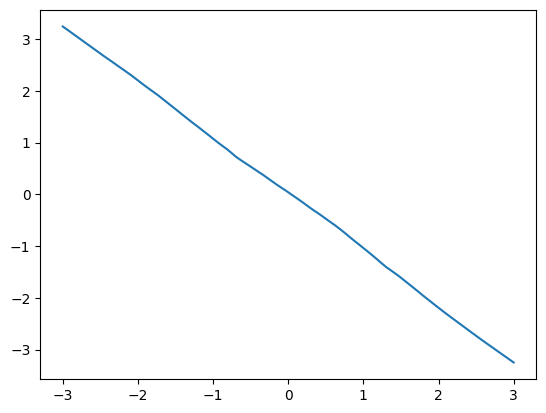

In [19]:
x = torch.linspace(-3, 3, 100)
x = torch.reshape(x, (100,1))
t = torch.ones((100, 1))
xt = torch.cat((x,t), dim = 1)
y = model(xt.to(device)).cpu().detach().numpy()
sns.lineplot(x = x.numpy()[:,0], y = y[:,0])

In [39]:
class NeuralNetwork2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 128),
            torch.nn.ReLU(),
            #torch.nn.Linear(128, 128),
            #torch.nn.ReLU(),
            torch.nn.Linear(128, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x[:, 1] = torch.log(sigma2(x[:,1]) + 1e-8)
        out = self.net(x)
        return out

In [40]:
from torch.optim import Adam
from torch.utils.data import DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
classifier = NeuralNetwork2()
classifier = classifier.to(device)

lr = 1e-4
optimizer_class = Adam(classifier.parameters(), lr = lr)

In [46]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64
dataset = TensorDataset(Data, ber.float())
data_loader_class = DataLoader(dataset, batch_size=batch_size, shuffle=True)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler_class = ReduceLROnPlateau(optimizer_class, mode='min', factor=0.1, patience=10)

In [103]:
import torch

def sample(t, x0, M, b_min=0.1, b_max=20.0):
    '''
    x0: A matrix (n, d)
    t: A vector with size (k)
    return sample of size (n*k*M, d+1)
    '''
    n, d = x0.shape
    k = t.shape[0]
    mean = mu(t)
    var = sigma2(t)

    mean = mean.repeat_interleave(n * M)
    var = var.repeat_interleave(n * M)
    x0_repeated = x0.repeat(k * M, 1)

    samples = torch.normal(x0_repeated * mean[:, None], torch.sqrt(var)[:, None])
    t_repeated = t.repeat_interleave(n * M).unsqueeze(1)
    samples = torch.cat((samples, t_repeated), dim=1)

    return samples

import torch.nn.functional as F

def loss_fn_class(model_class, x, y, b_min=0.1, b_max=20.0, M=30, eps=0, T=1.0, N=20):
    #step = (T - eps) / N
    #t_ = torch.arange(eps, T, step, device=x.device)
    #t_ = torch.cat((t_, torch.tensor([0.], device=x.device)))
    alpha = 3.0
    beta = 1.0
    beta_dist = torch.distributions.Beta(alpha, beta)
    t_ = beta_dist.sample((N,)).to(device)
    t_ = torch.cat((t_, torch.tensor([0.], device=x.device)))

    samples = sample(t_, x, M, b_min=b_min, b_max=b_max)

    #x_repeated = x.repeat(samples.shape[0] // x.shape[0], 1)
    y_repeated = y.repeat(samples.shape[0] // y.shape[0], 1)

    predict = model_class(samples)
    loss = F.binary_cross_entropy(predict, y_repeated)
    return loss


In [105]:
# treino
from tqdm import tqdm
import gc

n_epochs = 5001
for epoch in tqdm(range(n_epochs), desc="Training Epochs"):
  avg_loss = 0.
  num_items = 0
  for (x,y) in data_loader_class:
    optimizer_class.zero_grad()
    x = x.to(device)
    y = y.to(device)
    loss = loss_fn_class(classifier, x, y, M = 20, N = 50, eps = 0, T = 0.7)
    loss.backward()
    optimizer_class.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]

  del x, y, loss # Delete tensors after they are used
  gc.collect() # Run garbage collection to free up memory
  torch.cuda.empty_cache() # Empty CUDA cache

  if epoch % 100 == 0:
    print('epoch:', epoch)
    print('Average Loss: {:5f}'.format(avg_loss / num_items))
    scheduler_class.step(avg_loss / num_items)

Training Epochs:   0%|          | 1/5001 [00:01<1:46:47,  1.28s/it]

epoch: 0
Average Loss: 0.597666


Training Epochs:   0%|          | 4/5001 [00:06<2:13:56,  1.61s/it]


KeyboardInterrupt: 

In [108]:
from scipy.integrate import solve_ivp
def function_flow_class(t, x, model, classifier):
  def beta(t):
    b_min = 0.1
    b_max = 20.
    return b_min + (b_max - b_min)*t
  T = 1
  f = -beta(T-t)*x/2
  g2 = beta(T-t)
  model.eval()
  with torch.no_grad():
    xpt = torch.tensor([x]).to(device).float()
    tpt = torch.tensor([[T-t]]).to(device).float()
    xt = torch.cat((xpt, tpt), dim = 1)
    score_model = model(xt)
    score_class = classifier(xt)
    score = score_model + score_class
  score = score.detach().cpu().numpy()
  out = f - (g2)*score/2
  return -out

def generate_by_flow_ODE_class(model, classifier, T = 1, b_min = 0.1, b_max = 20):
  model = model
  X = np.random.randn(1)
  eps = 1e-5
  def function_ode(t, x):
    return function_flow_class(t, x, model, classifier)
  sol = solve_ivp(function_ode, [0, T], X, first_step = 1e-5)
  return sol.y.T

In [109]:
genereate_x = []
for i in range(1000):
    sample_new = generate_by_flow_ODE_class(model, classifier)
    genereate_x.append(sample_new[-1])

<Axes: ylabel='Density'>

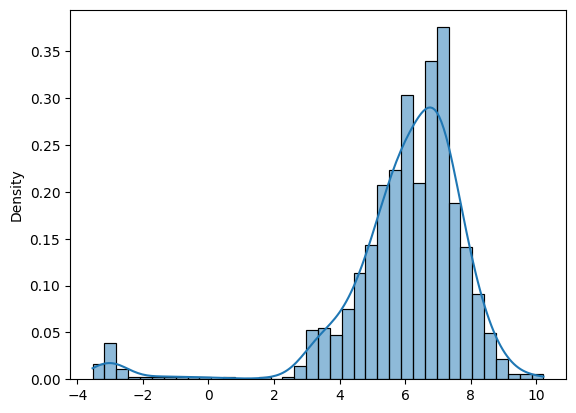

In [110]:
sns.histplot(np.array(genereate_x)[:,0], stat='density', kde = True)